In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [3]:
constructor_standings= pd.read_csv('./data_files/constructor_standings.csv')
constructors = pd.read_csv('./data_files/constructors.csv')
races = pd.read_csv('./data_files/races.csv')

In [4]:
constructor_standings

,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
0,1,18,1,14.0,1,1,1
1,2,18,2,8.0,3,3,0
2,3,18,3,9.0,2,2,0
3,4,18,4,5.0,4,4,0
4,5,18,5,2.0,5,5,0
...,...,...,...,...,...,...,...
12711,27938,1074,210,0.0,6,-,0
12712,27939,1074,1,0.0,7,-,0
12713,27940,1074,131,0.0,8,-,0
12714,27941,1074,9,0.0,9,-,0


In [5]:
constructors.drop(columns='url', inplace=True)

In [6]:
constructors_dict = constructors[['name','constructorId']].set_index('constructorId').to_dict()['name']

In [7]:
constructor_standings['Team Name'] = constructor_standings['constructorId'].replace(constructors_dict)

### Fixing team names that are under the same parent company just rebranded

In [8]:
changed_team_names = {
    'Racing Point' :'Aston Martin',
    'Force India'  :'Aston Martin',
    'Alpine F1 Team' : 'Alpine',
    'Renault' : 'Alpine',
    'Lotus' : 'Caterham',
    'Lotus F1' : 'Caterham',
    'Toro Rosso' : 'AlphaTauri',
    'Sauber' :'Alfa Romeo',
    'Marussia' :'Manor Marussia',
    'Virgin' : 'Manor Marussia',
    'Haas F1 Team' : 'Haas'
}
constructor_standings['Team Name'].replace(changed_team_names, inplace=True)
constructor_standings

,constructorStandingsId,raceId,constructorId,points,position,positionText,wins,Team Name
0,1,18,1,14.0,1,1,1,McLaren
1,2,18,2,8.0,3,3,0,BMW Sauber
2,3,18,3,9.0,2,2,0,Williams
3,4,18,4,5.0,4,4,0,Alpine
4,5,18,5,2.0,5,5,0,AlphaTauri
...,...,...,...,...,...,...,...,...
12711,27938,1074,210,0.0,6,-,0,Haas
12712,27939,1074,1,0.0,7,-,0,McLaren
12713,27940,1074,131,0.0,8,-,0,Mercedes
12714,27941,1074,9,0.0,9,-,0,Red Bull


#### Only the current 10 teams parcipating in formula one

In [9]:
current_teams = ['Ferrari','McLaren','Red Bull','Mercedes','Aston Martin','Williams','Alpine','AlphaTauri','Alfa Romeo','Haas']
constructor_standings = constructor_standings[constructor_standings['Team Name'].isin(current_teams)]

In [10]:
constructor_standings

,constructorStandingsId,raceId,constructorId,points,position,positionText,wins,Team Name
0,1,18,1,14.0,1,1,1,McLaren
2,3,18,3,9.0,2,2,0,Williams
3,4,18,4,5.0,4,4,0,Alpine
4,5,18,5,2.0,5,5,0,AlphaTauri
5,6,18,6,1.0,6,6,0,Ferrari
...,...,...,...,...,...,...,...,...
12711,27938,1074,210,0.0,6,-,0,Haas
12712,27939,1074,1,0.0,7,-,0,McLaren
12713,27940,1074,131,0.0,8,-,0,Mercedes
12714,27941,1074,9,0.0,9,-,0,Red Bull


In [11]:
raceId_years = races[['raceId', 'year']].set_index('raceId').to_dict()['year']

adding year column for ease of separation and removing 2022 since that season has not started at current time

In [12]:
constructor_standings['Year'] = constructor_standings['raceId'].replace(raceId_years)
constructor_standings = constructor_standings[constructor_standings['Year'] != 2022]

<ipython-input-12-3fba8298a30a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  constructor_standings['Year'] = constructor_standings['raceId'].replace(raceId_years)


The best way to keep the values even between each team is to track only the last 10 years.\
It would be unfair to track farrari vs haas when farrari have been competing since the 1950s and haas only joined in 2016.

In [13]:
constructor_standings.drop_duplicates(['Year','Team Name'], keep='last').sort_values(by='Year')
constructor_standings = constructor_standings[constructor_standings['Year'] >=2010]

In [14]:
constructor_standings['Team Name'].value_counts()

Williams        237
Red Bull        237
Aston Martin    237
McLaren         237
Mercedes        237
AlphaTauri      237
Ferrari         237
Alfa Romeo      236
Alpine          160
Haas            122
Name: Team Name, dtype: int64

Final Cleaning for model predictions

In [15]:
constructor_standings.drop(columns=['constructorStandingsId','raceId','constructorId', 'positionText'], inplace=True)
constructor_standings

,points,position,wins,Team Name,Year
10127,43.0,1,1,Ferrari,2010
10128,21.0,2,0,McLaren,2010
10129,16.0,4,0,Red Bull,2010
10130,18.0,3,0,Mercedes,2010
10131,2.0,5,0,Aston Martin,2010
...,...,...,...,...,...
12701,77.0,7,0,Aston Martin,2021
12702,13.0,9,0,Alfa Romeo,2021
12703,155.0,5,1,Alpine,2021
12704,23.0,8,0,Williams,2021


Machine Learning Models

In [16]:
y = constructor_standings['position']
X = constructor_standings.drop(columns='position')

In [17]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state=42)

In [18]:
X_train['Team Name']

10166      Mercedes
11842        Alpine
11397       Ferrari
11645      Williams
12352       Ferrari
            ...    
12167      Red Bull
11616        Alpine
11655      Mercedes
11823    Alfa Romeo
11342    AlphaTauri
Name: Team Name, Length: 1632, dtype: object

One hot enconder

In [19]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
train_ohe = X_train[['Team Name']]
test_ohe = X_test[['Team Name']]

train_ohe = ohe.fit_transform(train_ohe)
test_ohe = ohe.transform(test_ohe)

Standard Scaler

In [20]:
scaler = StandardScaler()

scaled_train = X_train.drop(columns= 'Team Name')
scaled_test = X_test.drop(columns= 'Team Name')

scaled_train = scaler.fit_transform(scaled_train)
scaled_test = scaler.transform(scaled_test)

Concatenate both the ohe and standar scaler

In [21]:
X_train = np.concatenate((train_ohe, scaled_train), axis=1)
X_test = np.concatenate((test_ohe, scaled_test), axis=1)

#### Defualt KNN Regressor

In [22]:
knn  = KNeighborsRegressor()
knn.fit(X_train, y_train)

print(f'Train: {knn.score(X_train, y_train)}')
print(f'Test: {knn.score(X_test, y_test)}')

Train: 0.9614681362940193
Test: 0.9503319223741123


knn gridSearch

In [23]:
knn_params = {
    'n_neighbors' : [5,10,50,100], 
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto','ball_tree', 'kd_tree'], 
    'p' : [2, 1],
    'metric' :['minkowski', 'manhattan', 'euclidean', 'chebyshev']
}

In [24]:
knn_grid = GridSearchCV(KNeighborsRegressor(), param_grid=knn_params)

knn_grid.fit(X_train, y_train)

knn_grid.best_params_

{'algorithm': 'ball_tree',
 'metric': 'minkowski',
 'n_neighbors': 5,
 'p': 1,
 'weights': 'distance'}

#### KNN Best params

In [25]:
knn  = KNeighborsRegressor(algorithm = 'ball_tree',metric= 'minkowski', n_neighbors= 5, p = 1,weights='distance')
knn.fit(X_train, y_train)

print(f'Train: {knn.score(X_train, y_train)}')
print(f'Test: {knn.score(X_test, y_test)}')

Train: 0.9934948205147692
Test: 0.9542998502680763


#### Defualt Random Forest

In [26]:
rf  = RandomForestRegressor()
rf.fit(X_train, y_train)

print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 0.9851055345641683
Test: 0.9347005696464059


In [27]:
rf_params = { 
    'n_estimators' : [50, 100, 150, 200],
    'max_features' : ['auto', 'sqrt', 'log2'], 
    'bootstrap' : [True, False], 
    'warm_start' : [True, False]
}

#### GridSearch for Random forest

In [28]:
rf_grid = GridSearchCV(RandomForestRegressor(), param_grid=rf_params)

rf_grid.fit(X_train, y_train)

rf_grid.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'n_estimators': 50,
 'warm_start': False}

##### Random Forest best params

In [29]:
rf  = RandomForestRegressor(bootstrap = False, max_features='log2', n_estimators= 150, warm_start=True)
rf.fit(X_train, y_train)

print(f'Train: {rf.score(X_train, y_train)}')
print(f'Test: {rf.score(X_test, y_test)}')

Train: 0.9936658594894896
Test: 0.9437354689626775


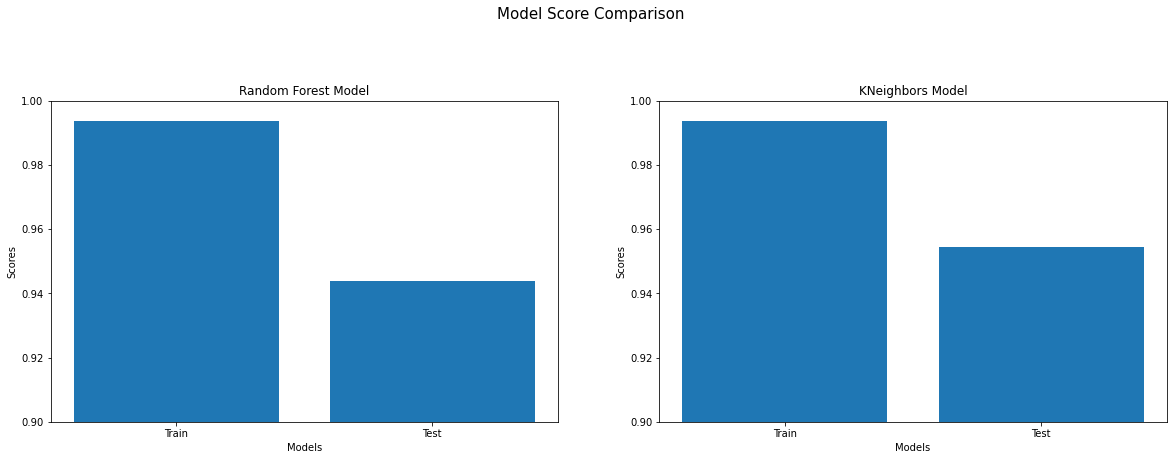

In [32]:
fig = plt.figure(figsize=(20,13))
fig.suptitle('Model Score Comparison', fontsize=15)

ax1= plt.subplot(221)
ax2= plt.subplot(222)



ax1.bar(['Train', 'Test'], [rf.score(X_train, y_train), rf.score(X_test, y_test)])
ax1.set_title('Random Forest Model')
ax1.set_ylabel('Scores')
ax1.set_xlabel('Models')
ax1.set_ylim(.9,1)

ax2.bar(['Train', 'Test'], [knn.score(X_train, y_train), knn.score(X_test, y_test)])
ax2.set_title('KNeighbors Model')
ax2.set_ylabel('Scores')
ax2.set_xlabel('Models')
ax2.set_ylim(.9,1)
plt.show()
